## Importing Libraries and Modules


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor, SGDClassifier, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, r2_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import time
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline



## Load Dataset


In [3]:
df = pd.read_csv("heart.csv")

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Splitting Features for Classification and Regression


In [4]:
X_class = df.drop("HeartDisease", axis=1)
y_class = df["HeartDisease"]

X_regr = df.drop("Cholesterol", axis=1)
y_regr = df["Cholesterol"]

In [5]:
num_class = X_class.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_class = X_class.select_dtypes(include=["object"]).columns.tolist()


## Preprocessing Pipelines: Numerical and Categorical


In [6]:
num_features_regr = X_regr.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_regr = X_regr.select_dtypes(include=["object"]).columns.tolist()

## Regression & Classification Pipelines


In [7]:
num_pipeline_regr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline_regr = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

full_pipeline_regr = ColumnTransformer([
    ("num", num_pipeline_regr, num_features_regr),
    ("cat", cat_pipeline_regr, cat_features_regr)
])

full_regr_pipeline = Pipeline([
    ("preprocessor", full_pipeline_regr),
    ("reg", Ridge())
])

In [8]:
class_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_class),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_class)
])

full_class_pipeline = Pipeline([
    ("preprocessor", class_pipeline),
    ("clf", LogisticRegression(max_iter=1000))
])

## Learning Curve Plotting Function


In [9]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", scoring=None, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, "o-", label="Training")
    plt.plot(train_sizes, val_mean, "o-", label="Validation")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()


## Train/Test Split for Regression


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_regr, y_regr, test_size=0.2, random_state=42)


## Train and Evaluate Regression Models with Learning Curves

- Linear Regression
- SGD Regressor
- Ridge
- Lasso
- SGD Classifier
- Logistic Regression


In [11]:
full_regr_pipeline.set_params(reg=LinearRegression())

full_regr_pipeline.fit(X_train, y_train)

lin_preds = full_regr_pipeline.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))
print("Linear Regression RMSE:", lin_rmse)

Linear Regression RMSE: 107.05079733405982


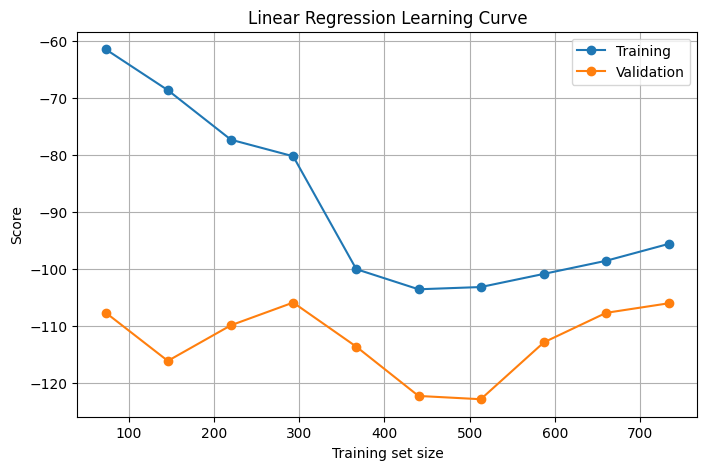

In [12]:
# full_regr_pipeline.set_params(reg=LinearRegression())

plot_learning_curve(full_regr_pipeline,X_regr,y_regr,title="Linear Regression Learning Curve",scoring="neg_root_mean_squared_error")

In [13]:
full_regr_pipeline.set_params(reg=SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))

full_regr_pipeline.fit(X_train, y_train)

sgd_preds = full_regr_pipeline.predict(X_test)
sgd_rmse = np.sqrt(mean_squared_error(y_test, sgd_preds))
print("SGD Regressor RMSE:", sgd_rmse)

SGD Regressor RMSE: 107.22302748705458


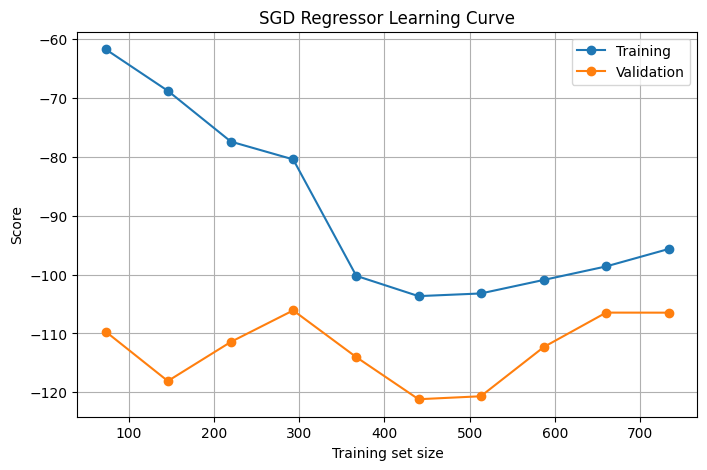

In [14]:
full_regr_pipeline.set_params(reg=SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))

plot_learning_curve(full_regr_pipeline,X_regr,y_regr,title="SGD Regressor Learning Curve",scoring="neg_root_mean_squared_error")

In [15]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

full_class_pipeline.set_params(clf=SGDClassifier(random_state=42))

full_class_pipeline.fit(Xc_train, yc_train)

y_clf_pred = full_class_pipeline.predict(Xc_test)
print(classification_report(yc_test, y_clf_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        77
           1       0.90      0.81      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



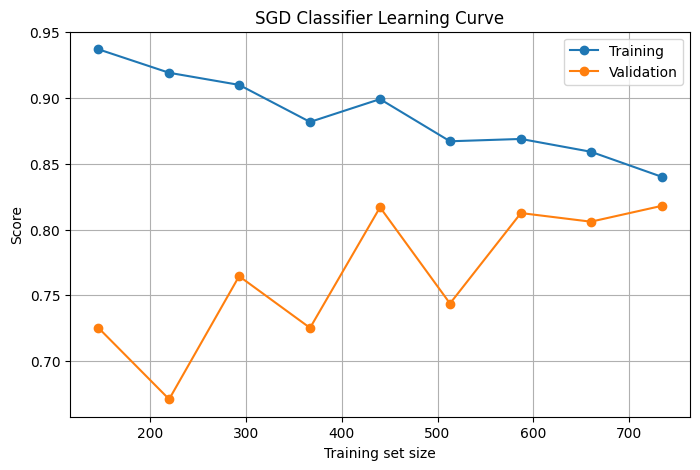

In [16]:
full_class_pipeline.set_params(clf=SGDClassifier(random_state=42))

plot_learning_curve(full_class_pipeline,X_class,y_class,title="SGD Classifier Learning Curve",scoring="accuracy")

In [17]:
full_regr_pipeline.set_params(reg=Ridge(alpha=1.0))

full_regr_pipeline.fit(X_train, y_train)

ridge_preds = full_regr_pipeline.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print("Ridge RMSE:", ridge_rmse)

Ridge RMSE: 107.02617607490478


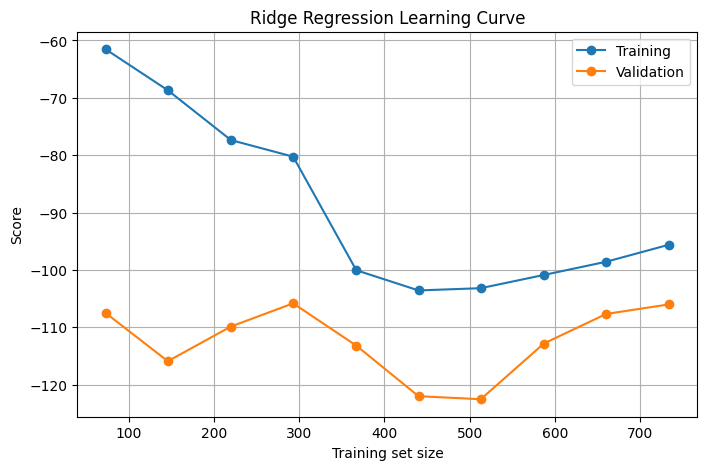

In [18]:
full_regr_pipeline.set_params(reg=Ridge(alpha=1.0)) 

plot_learning_curve(full_regr_pipeline,X_regr,y_regr,title="Ridge Regression Learning Curve",scoring="neg_root_mean_squared_error")

In [19]:
# Lasso Regression
full_regr_pipeline.set_params(reg=Lasso(alpha=0.1)) 
full_regr_pipeline.fit(X_train, y_train)
lasso_preds = full_regr_pipeline.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
print("Lasso RMSE:", lasso_rmse)

Lasso RMSE: 106.92347538734292


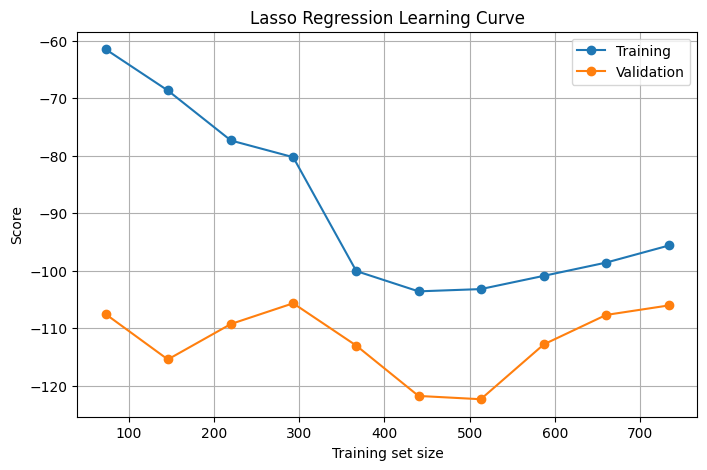

In [20]:
full_regr_pipeline.set_params(reg=Lasso(alpha=0.1))

plot_learning_curve(full_regr_pipeline,X_regr,y_regr,title="Lasso Regression Learning Curve",scoring="neg_root_mean_squared_error")

In [21]:
full_class_pipeline.set_params(clf=LogisticRegression(max_iter=1000, random_state=42))

full_class_pipeline.fit(Xc_train, yc_train)

y_pred_logreg = full_class_pipeline.predict(Xc_test)

print("Logistic Regression Classification Report:")
print(classification_report(yc_test, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



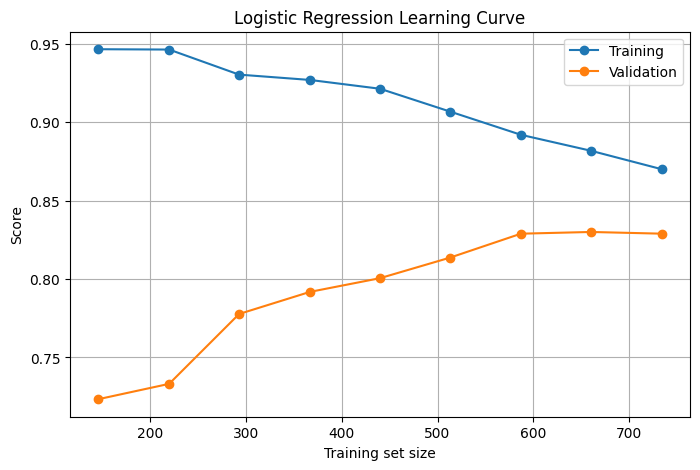

In [22]:
full_class_pipeline.set_params(clf=LogisticRegression(max_iter=1000, random_state=42))

plot_learning_curve(full_class_pipeline,X_class,y_class,title="Logistic Regression Learning Curve",scoring="accuracy")

## Hyperparameter Tuning with GridSearchCV - Regression


In [23]:
param_grid_regr = [
    {
        "reg": [LinearRegression()]
    },
    {
        "reg": [Ridge(), Lasso()],
        "reg__alpha": [0.01, 0.1, 1.0, 10.0]
    },
    {
        "reg": [SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)],
        "reg__alpha": [0.0001, 0.001, 0.01, 0.1]
    }
]

grid_search_regr = GridSearchCV(estimator=full_regr_pipeline,param_grid=param_grid_regr,scoring="neg_root_mean_squared_error",cv=5,n_jobs=-1)

grid_search_regr.fit(X_regr, y_regr)

print("Best Regressor:", grid_search_regr.best_params_)
print("Best RMSE:", -grid_search_regr.best_score_)

Best Regressor: {'reg': Ridge(), 'reg__alpha': 10.0}
Best RMSE: 105.88151296668903


## Hyperparameter Tuning with GridSearchCV - Classification


In [24]:
param_grid_class = [
    {
        "clf": [LogisticRegression(max_iter=1000, solver="liblinear")],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [0.01, 0.1, 1.0, 10.0]  # inverse of regularization strength
    },
    {
        "clf": [SGDClassifier(random_state=42)],
        "clf__penalty": ["l2", "l1", "elasticnet"],
        "clf__alpha": [0.0001, 0.001, 0.01]  # regularization strength
    }
]

grid_search_class = GridSearchCV(
    estimator=full_class_pipeline,
    param_grid=param_grid_class,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid_search_class.fit(X_class, y_class)

print("Best Classifier:", grid_search_class.best_params_)
print("Best Accuracy:", grid_search_class.best_score_)


Best Classifier: {'clf': SGDClassifier(random_state=42), 'clf__alpha': 0.01, 'clf__penalty': 'l2'}
Best Accuracy: 0.8354597291518175


## Model Evaluation Functions (Regression & Classification)


In [25]:
def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {"Model": name, "RMSE": rmse, "R²": r2, "Train Time (s)": duration}


In [26]:
def evaluate_classification_model(name, model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {"Model": name, "Accuracy": accuracy, "F1 Score": f1, "Train Time (s)": duration}


## Model Comparison Tables


In [27]:
regression_models = {
    "Linear Regression": make_pipeline(
        ColumnTransformer([
            ("num", num_pipeline_regr, num_features_regr),
            ("cat", cat_pipeline_regr, cat_features_regr)
        ]),
        LinearRegression()
    ),
    "Ridge": make_pipeline(
        ColumnTransformer([
            ("num", num_pipeline_regr, num_features_regr),
            ("cat", cat_pipeline_regr, cat_features_regr)
        ]),
        Ridge(alpha=1.0)
    ),
    "Lasso": make_pipeline(
        ColumnTransformer([
            ("num", num_pipeline_regr, num_features_regr),
            ("cat", cat_pipeline_regr, cat_features_regr)
        ]),
        Lasso(alpha=0.1)
    ),
    "SGD Regressor": make_pipeline(
        ColumnTransformer([
            ("num", num_pipeline_regr, num_features_regr),
            ("cat", cat_pipeline_regr, cat_features_regr)
        ]),
        SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
    )
}


In [28]:
reg_results = []
for name, model in regression_models.items():
    result = evaluate_regression_model(name, model, X_train, y_train, X_test, y_test)
    reg_results.append(result)

reg_results_df = pd.DataFrame(reg_results)
print("\n Regression Model Comparison:\n", reg_results_df)



 Regression Model Comparison:
                Model        RMSE        R²  Train Time (s)
0  Linear Regression  107.050797  0.115832        0.036506
1              Ridge  107.026176  0.116239        0.025385
2              Lasso  106.923475  0.117934        0.013222
3      SGD Regressor  107.223027  0.112985        0.022112


In [29]:
classification_models = {
    "Logistic Regression": make_pipeline(
        class_pipeline,
        LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
    ),
    "SGD Classifier": make_pipeline(
        class_pipeline,
        SGDClassifier(random_state=42)
    )
}

In [30]:
class_results = []
for name, model in classification_models.items():
    result = evaluate_classification_model(name, model, Xc_train, yc_train, Xc_test, yc_test)
    class_results.append(result)

class_results_df = pd.DataFrame(class_results)
print("\n Classification Model Comparison:\n", class_results_df)



 Classification Model Comparison:
                  Model  Accuracy  F1 Score  Train Time (s)
0  Logistic Regression  0.853261  0.869565        0.025669
1       SGD Classifier  0.836957  0.852941        0.020849


## Feature Names for Feature Importance


In [31]:
feature_names = full_pipeline_regr.get_feature_names_out()

In [32]:
feature_names = class_pipeline.get_feature_names_out()

In [ ]:
# Feature Importance Function
def show_feature_importance(model_pipeline, model_name):
    model = model_pipeline.named_steps[model_name]  # 'reg' or 'clf'

    if hasattr(model, "coef_"):
        importance = model.coef_[0] if model.coef_.ndim > 1 else model.coef_
        df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance
        }).sort_values("Importance", key=np.abs, ascending=False)
        print(f"\n {model_name} Feature Importance:\n", df.head(10))

    elif hasattr(model, "feature_importances_"):
        df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        }).sort_values("Importance", ascending=False)
        print(f"\n {model_name} Feature Importances:\n", df.head(10))

    else:
        print(f"Feature importance not available for model: {model_name}")


In [34]:
show_feature_importance(regression_models["Linear Regression"], "linearregression")
show_feature_importance(regression_models["Ridge"], "ridge")
show_feature_importance(regression_models["Lasso"], "lasso")
show_feature_importance(regression_models["SGD Regressor"], "sgdregressor")



 linearregression Feature Importance:
                    Feature  Importance
12     cat__RestingECG_LVH   31.677308
5             num__Oldpeak  -25.309756
14      cat__RestingECG_ST  -22.449236
10  cat__ChestPainType_NAP  -19.481092
2         num__Cholesterol  -19.276100
9   cat__ChestPainType_ATA   19.084175
17      cat__ST_Slope_Down  -17.037365
3           num__FastingBS   16.176150
4               num__MaxHR   15.756014
7               cat__Sex_M  -13.802328

 ridge Feature Importance:
                    Feature  Importance
12     cat__RestingECG_LVH   31.468600
5             num__Oldpeak  -25.234931
14      cat__RestingECG_ST  -22.277010
10  cat__ChestPainType_NAP  -19.319801
2         num__Cholesterol  -19.286690
9   cat__ChestPainType_ATA   18.953641
17      cat__ST_Slope_Down  -16.747870
3           num__FastingBS   16.181498
4               num__MaxHR   15.702897
6               cat__Sex_F   13.773121

 lasso Feature Importance:
                    Feature  Importance
12   

In [35]:
show_feature_importance(classification_models["Logistic Regression"], "logisticregression")
show_feature_importance(classification_models["SGD Classifier"], "sgdclassifier")



 logisticregression Feature Importance:
                    Feature  Importance
19        cat__ST_Slope_Up   -1.190090
18      cat__ST_Slope_Flat    1.152667
8   cat__ChestPainType_ASY    0.954290
6               cat__Sex_F   -0.698234
15   cat__ExerciseAngina_N   -0.623245
7               cat__Sex_M    0.537486
2         num__Cholesterol   -0.517239
10  cat__ChestPainType_NAP   -0.508680
5             num__Oldpeak    0.494490
9   cat__ChestPainType_ATA   -0.475106

 sgdclassifier Feature Importance:
                    Feature  Importance
18      cat__ST_Slope_Flat    1.856813
19        cat__ST_Slope_Up   -1.856813
2         num__Cholesterol   -1.836411
16   cat__ExerciseAngina_Y    1.591554
7               cat__Sex_M    1.326295
15   cat__ExerciseAngina_N   -1.326295
5             num__Oldpeak    1.126260
3           num__FastingBS    1.121496
8   cat__ChestPainType_ASY    1.061036
6               cat__Sex_F   -1.061036


## Excercise Q12

In [51]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [62]:
iris = load_iris()
X = iris.data
y = iris.target

X = (X - X.mean(axis=0)) / X.std(axis=0)

encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

C:\Users\Probook\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
W = np.random.randn(n_features, n_classes) * 0.01
b = np.zeros((1, n_classes))

In [64]:
def softmax(logits):
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def compute_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) ==
np.argmax(y_pred, axis=1))

In [65]:
learning_rate = 0.5
n_epochs = 300
patience = 3
best_val_loss = np.inf
best_weights = None
epochs_no_improve = 0

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    logits = np.dot(X_train, W) + b
    probs = softmax(logits)
    loss = compute_loss(y_train, probs)
    
    error = probs - y_train
    grad_W = np.dot(X_train.T, error) / len(X_train)
    grad_b = np.sum(error, axis=0, keepdims=True) / len(X_train)
    
    W -= learning_rate * grad_W
    b -= learning_rate * grad_b
    
    val_probs = softmax(np.dot(X_val, W) + b)
    val_loss = compute_loss(y_val, val_probs)
    
    train_losses.append(loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = (W.copy(), b.copy())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

W, b = best_weights

val_preds = softmax(np.dot(X_val, W) + b)
val_acc = compute_accuracy(y_val, val_preds)
print(f"\nFinal validation accuracy: {val_acc:.4f}")

Epoch 1 | Train Loss: 1.1114 | Val Loss: 0.7180
Epoch 2 | Train Loss: 0.7396 | Val Loss: 0.5826
Epoch 3 | Train Loss: 0.6135 | Val Loss: 0.5138
Epoch 4 | Train Loss: 0.5502 | Val Loss: 0.4700
Epoch 5 | Train Loss: 0.5100 | Val Loss: 0.4386
Epoch 6 | Train Loss: 0.4814 | Val Loss: 0.4144
Epoch 7 | Train Loss: 0.4594 | Val Loss: 0.3949
Epoch 8 | Train Loss: 0.4417 | Val Loss: 0.3786
Epoch 9 | Train Loss: 0.4271 | Val Loss: 0.3648
Epoch 10 | Train Loss: 0.4146 | Val Loss: 0.3527
Epoch 11 | Train Loss: 0.4037 | Val Loss: 0.3421
Epoch 12 | Train Loss: 0.3941 | Val Loss: 0.3327
Epoch 13 | Train Loss: 0.3855 | Val Loss: 0.3241
Epoch 14 | Train Loss: 0.3777 | Val Loss: 0.3163
Epoch 15 | Train Loss: 0.3705 | Val Loss: 0.3092
Epoch 16 | Train Loss: 0.3639 | Val Loss: 0.3027
Epoch 17 | Train Loss: 0.3577 | Val Loss: 0.2966
Epoch 18 | Train Loss: 0.3519 | Val Loss: 0.2909
Epoch 19 | Train Loss: 0.3464 | Val Loss: 0.2855
Epoch 20 | Train Loss: 0.3413 | Val Loss: 0.2805
Epoch 21 | Train Loss: 0.3363

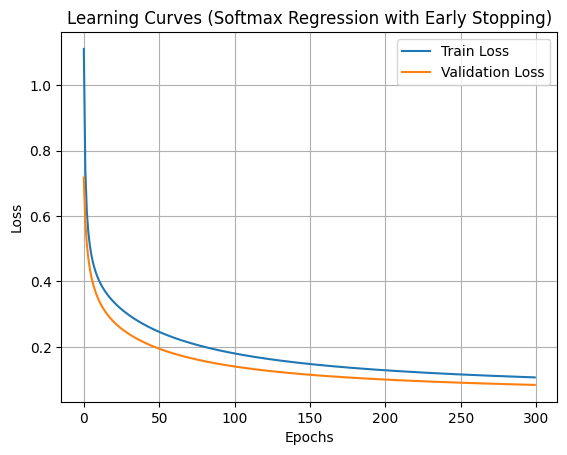

In [66]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves (Softmax Regression with Early Stopping)")
plt.legend()
plt.grid(True)
plt.show()